# 02_exploratory_data_analysis_realized_volatility_capstone_project

## Some questions to explore and answer 

1) Explore and understand the data for various stocks in the two key files: **book_train** and **trade_train**
        
* How do the 'wap' (weight average bid-ask price) and trade prices move during a time bucket ?
* Does 'wap' impact the 'trade price' or vice-versa ?
* Build some features from the data in the two files and see how these features are related to the 'realized_volatility'
* What is the distribution of realized volatility ? What about some other features like size, turnover ?

2) Understand how 'realized_volatility' moves with time. Is it auto-correlated? While we do not have data for sequential time buckets, we could create smaller **'time_segments'**, say 20-sec or 30-sec within the 10-minute time bucket and then calculate and visualize the 'realized_volatility' of these sequential time_segments.

3) Is realized_volatility of different stocks connected ? Are there any clusters of stocks with similar volatility across time buckets?


In [626]:
import pandas as pd
import numpy as np
import glob
from sb_utils import save_file

import seaborn as sns
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from scipy.stats import norm
import pylab

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, norm

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [1]:
#pip install fastparquet

In [2]:
#pip install pyarrow

## 1.0 Key Functions

Define important functions for performing various calculations and visualizations.


In [524]:

def log_return(list_stock_prices):
    # calculate the log return of a price series
    
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    # calculate the realized volatility using a series of log return for a stock
    
    return np.sqrt(np.sum(series_log_return**2))

def realized_volatility_per_time_id(file_path, prediction_column_name):
    # calculate the realized volatility for a single stock across multiple time ids in the file
    
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

def past_realized_volatility_per_stock(list_file,prediction_column_name):
    # calculate the realized volatility for a number of stock by passing a list of parquet file names
    
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

def high_low_index(price_series):
    # Calculate the value of highest price divided by lowest price for a time bucket
    
    return ((np.max(price_series) / np.min(price_series)))

def close_open_index(price_series):
    # Calculate the value of closing price divided by opening price for a time bucket
    
    return ((price_series.values[-1] / price_series.values[0]))

def rmspe(y_true, y_pred):
    # Calculate the root mean squared percentage. This is an evaluation criteria defined by Optiver.
    
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def book_params(df_book):
    ## calculate key parameters for book
  
    df_book['wap'] = (df_book.bid_price1*df_book.ask_size1 + df_book.ask_price1*df_book.bid_size1) \
                        /(df_book.ask_size1 + df_book.bid_size1)
    df_book['log_return'] = df_book.groupby(['time_id'])['wap'].apply(log_return)
    df_book['speed'] = df_book.groupby('time_id')['wap'].diff()
    df_book['speed'] = df_book['speed'].fillna(0.0)
    df_book['abs_speed_book'] = np.abs(df_book['speed'])
    df_book['abs_acceleration_book'] = np.abs(df_book.groupby('time_id')['speed'].diff())
       
    df_book.drop('speed', axis=1, inplace=True)
    df_book['abs_acceleration_book'] = df_book['abs_acceleration_book'].fillna(0.0)
        
    return df_book

def features_from_book(df_book):
    ## build key features using book parameters
    
    book_features = pd.DataFrame(df_book.groupby(['stock_id','time_id'])[['abs_speed_book', 'abs_acceleration_book']].sum()).reset_index()
      
    price_moves_book = pd.DataFrame(df_book.groupby('time_id')['wap'].agg([high_low_index, close_open_index])).reset_index()
    price_moves_book = price_moves_book.rename(columns = {'high_low_index': 'hl_index_book', 'close_open_index': 'clop_index_book'})
    book_features = book_features.merge(price_moves_book, on='time_id', how='left')
    
    book_vol = pd.DataFrame(df_book.groupby('time_id')['log_return'].agg(realized_volatility)).reset_index()
    book_vol = book_vol.rename(columns = {'log_return': "realized_vol_book"})
    book_features = book_features.merge(book_vol, on='time_id', how='left')
    
    return book_features


def trade_params(df_trade):
    ## calculate key parameters for trade file
    
    df_trade['log_return'] = df_trade.groupby(['time_id'])['price'].apply(log_return)
    df_trade['turnover'] = df_trade['price']*df_trade['size']
    df_trade['speed'] = df_trade.groupby(['time_id'])['price'].diff() / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff()

    df_trade['speed'] = df_trade['speed'].fillna(0.0)
    df_trade['abs_speed_trade'] = np.abs(df_trade['speed'])
    df_trade['abs_acceleration_trade'] = np.abs(df_trade.groupby(['time_id'])['speed'].diff() / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff())
     
    df_trade.drop('speed', axis=1, inplace=True)
    df_trade['abs_acceleration_trade'] = df_trade['abs_acceleration_trade'].fillna(0.0)
    
    df_trade['momentum'] = df_trade['abs_speed_trade'] * df_trade['size']
    df_trade['abs_force_trade'] = df_trade['abs_acceleration_trade'] * df_trade['size']
    
    
    df_trade = df_trade[~df_trade['log_return'].isnull()]

    return df_trade

def features_from_trade(df_trade):
    ## build key features using trade parameters
    
    trade_features = pd.DataFrame(\
                    df_trade.groupby('time_id')[['turnover','size','order_count','abs_speed_trade', \
                    'abs_acceleration_trade','momentum', 'abs_force_trade']].sum()).reset_index()
        
    price_moves_trade = pd.DataFrame(df_trade.groupby('time_id')['price'].agg([high_low_index, close_open_index])).reset_index()
    price_moves_trade = price_moves_trade.rename(columns = {'high_low_index': 'hl_index_trade', 'close_open_index': 'clop_index_trade'})
    trade_features = trade_features.merge(price_moves_trade, on='time_id', how='left')
    
    trade_vol = pd.DataFrame(df_trade.groupby('time_id')['log_return'].agg(realized_volatility)).reset_index()
    trade_vol = trade_vol.rename(columns = {'log_return': "realized_vol_trade"})
    trade_features = trade_features.merge(trade_vol, on='time_id', how='left')
    
    return trade_features

def initialize_trade_price(df_trade, df_book):
    ## A function to initialize trade price to wap in the second just before the 1st trade. this helps to see how much
    ## the first trade price moved vs the prevailing wap. this is done only when the 1st trade doesn't happen at 0 second.
    
    df_new = pd.DataFrame()

    for time_id in df_trade['time_id'].unique():
        idx = df_trade[df_trade['time_id'] == time_id]['seconds_in_bucket'].unique()
        if 0 not in idx:
            idx = np.append([idx[0]-1], idx)
            df_temp = df_trade[df_trade['time_id'] == time_id].set_index('seconds_in_bucket')
            df_temp = df_temp.reindex(idx).reset_index()
            df_temp['time_id'] = df_temp['time_id'].bfill()
            idx_book = df_book[df_book['time_id'] == time_id].index[0] + idx[0]
            df_temp.loc[0, "price"] = df_book.loc[idx_book, "wap"]
        
        else:
            df_temp = df_trade[df_trade['time_id'] == time_id]
    
        df_new = pd.concat([df_new, df_temp], ignore_index=True)
        
    return df_new



In [641]:
# define useful functions to create various visualizations to graphically understand and analyse the data 

def scatterplots(df, columns, target_col, ncol=None, figsize=(15, 8)):
    ## plot scatter plots amongst two features to get a visual sense of the correlation
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    #plt.suptitle("Correlation plot: Features and Target for Stock_id =" +str(df.stock_id.unique()[0]), fontsize=16)
    plt.suptitle("Correlation plots", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = target_col, data=df, alpha=0.5)
        ax.set_xlabel(col, fontsize=14)
        ax.set_ylabel(target_col, fontsize=14)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    plt.tight_layout()
    plt.show()
        
def densityplots(df, columns, ncol=None, figsize=(15, 8)):
    ## plot density plots for each feature to visually inspect the distribution
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Density plots of various features", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sns.kdeplot(df[col], bw_adjust = 0.05, ax=ax)
        #ax.set(xlabel=col, ylabel=target_col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
def plot_cluster_sse(df, features, ncols=None, figsize=(15,9)):
    ## plot the sum of squared error metric for different no. of clusters 
    
    sns.set_style('whitegrid')
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Error vs No. of clusters\n", fontsize=18)
    
    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        ss_error = []

        K_vals = np.arange(2,11)
        for K in K_vals:
            model = KMeans(n_clusters = K, random_state=123)
            labels = model.fit_predict(x_cols)
            centroids = model.cluster_centers_
            ss_error.append(np.sum((x_cols - centroids[labels])**2))

        ax = axes.flatten()[idx]
        ax.plot(K_vals, ss_error)
        ax.set_xlabel('No. of Clusters')
        ax.set_ylabel('Sum of Squared Error')
        ax.set_title('Feature: '+feature, fontsize=14)
    
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_clusters(df, features, nclusters = 4, ncols=None, figsize=(15,9)):
    ## plot clusters for the stocks across two principal components
    
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("No. of clusters by feature\n", fontsize=18)
    colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange'}
    red_patch = mpatches.Patch(color='red', label = 'Cluster 1')
    green_patch = mpatches.Patch(color='green', label = 'Cluster 2')
    blue_patch = mpatches.Patch(color='blue', label = 'Cluster 3')
    orange_patch = mpatches.Patch(color='orange', label = 'Cluster 4')

    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        
        kmeans = KMeans(n_clusters=nclusters, random_state = 123)
        labels = kmeans.fit_predict(x_cols)
        model = PCA(n_components=2)
        model.fit(x_cols)
        transformed = model.transform(x_cols)

        df_transformed = pd.DataFrame({'stock': np.array(df_feature.columns[1:]), 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})
        
        ax = axes.flatten()[idx]
        ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

        #ax.legend(handles=[red_patch, green_patch, blue_patch, orange_patch])
        ax.set_xlabel('Principal Component_1')
        ax.set_ylabel('Principal Component_2')
        ax.set_title('Feature: '+feature, fontsize=15)
        
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
def qqplots(df, columns, ncol=None, figsize=(15, 8)):
    # plot qqplots to test whether a distribution of data points is normal or not
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("QQ plots of features to check for normality", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sm.qqplot(df[col], line='45', ax=ax)
        ax.set_title(col, fontsize=14)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

    plt.show()


# Exploring the data

Let's look into the book and trade files of stock_id=0 and understand and plot a few paramters & features.

## Book File 

In [528]:
book = pd.read_csv('../WIP_data/book/train/stock_0_book_train.csv')
book.head()

,seconds_in_bucket,time_id,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,0,5.0,1.001422,1.002301,1.00137,1.002353,3.0,226.0,2.0,100.0,0
1,1,5.0,1.001422,1.002301,1.00137,1.002353,3.0,100.0,2.0,100.0,0
2,2,5.0,1.001422,1.002301,1.00137,1.002353,3.0,100.0,2.0,100.0,0
3,3,5.0,1.001422,1.002301,1.00137,1.002353,3.0,100.0,2.0,100.0,0
4,4,5.0,1.001422,1.002301,1.00137,1.002353,3.0,100.0,2.0,100.0,0


In [274]:
book.shape

(1838400, 11)

In [529]:
# Calculate a few parameters like log_return, wap etc.

book = book_params(book)
book.head()

,seconds_in_bucket,time_id,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return,abs_speed_book,abs_acceleration_book
0,0,5.0,1.001422,1.002301,1.00137,1.002353,3.0,226.0,2.0,100.0,0,1.001434,NaN,0.000000,0.000000
1,1,5.0,1.001422,1.002301,1.00137,1.002353,3.0,100.0,2.0,100.0,0,1.001448,0.000014,0.000014,0.000014
2,2,5.0,1.001422,1.002301,1.00137,1.002353,3.0,100.0,2.0,100.0,0,1.001448,0.000000,0.000000,0.000014
3,3,5.0,1.001422,1.002301,1.00137,1.002353,3.0,100.0,2.0,100.0,0,1.001448,0.000000,0.000000,0.000000
4,4,5.0,1.001422,1.002301,1.00137,1.002353,3.0,100.0,2.0,100.0,0,1.001448,0.000000,0.000000,0.000000


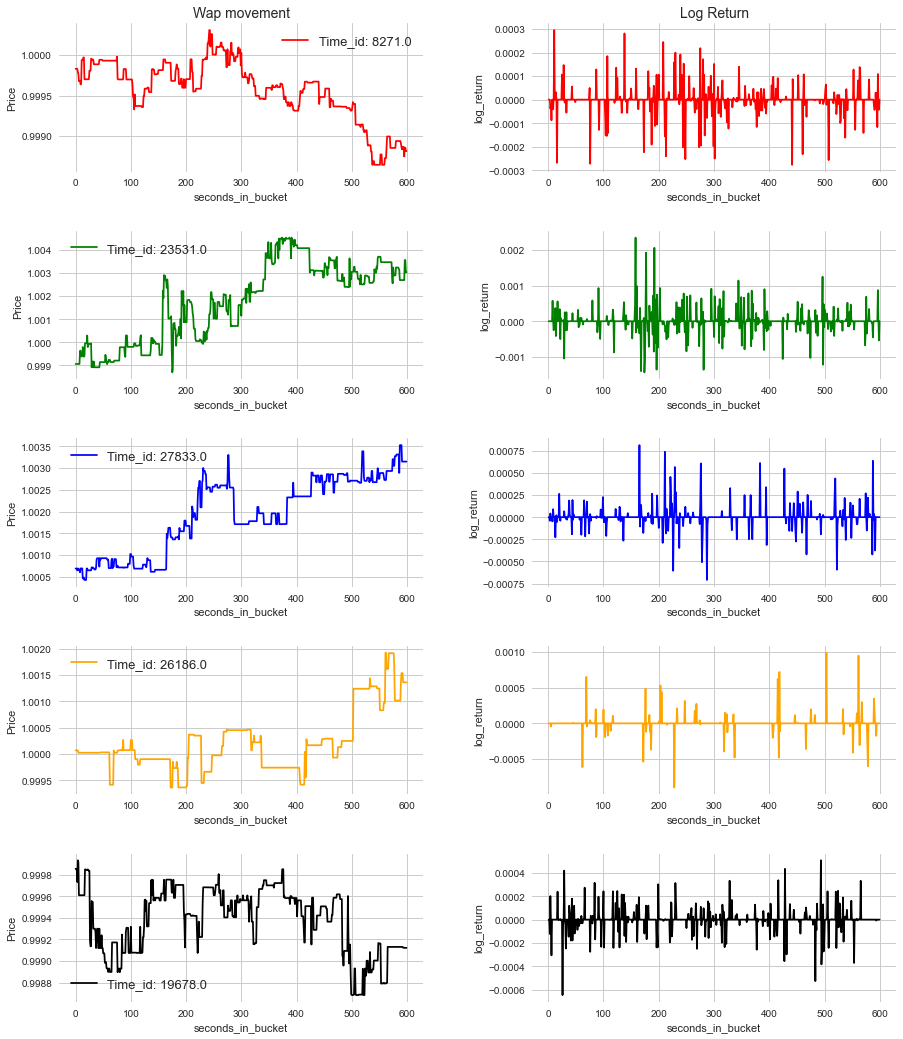

In [594]:
# Let's plot the wap and log returns

import random

fig, axes = plt.subplots(5,2, figsize = (15,18))
time_ids = random.sample(sorted(book['time_id'].unique()), 5)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange', 4:'black'}

for i, time_id in enumerate(time_ids):
    
    ax = axes.flatten()[i*2]
    ax.plot(np.arange(0,600), book[book['time_id'] == time_id]['wap'], label = "Time_id: "+str(time_id), c= colors[i])
    ax.set_ylabel('Price')
    ax.set_xlabel('seconds_in_bucket')
    ax.legend(fontsize=13)
    
    ax1 = axes.flatten()[i*2+1]
    ax1.plot(np.arange(0,600), book[book['time_id'] == time_id]['log_return'], c= colors[i])
    ax1.set_ylabel('log_return')
    ax1.set_xlabel('seconds_in_bucket')
    if i==0:
        ax.set_title('Wap movement', fontsize=14)
        ax1.set_title("Log Return", fontsize=14)

plt.show()


**Observations**: 
1) The wap movements seem like random walks. wap is the weighted average price derived from the top bid-ask prices and sizes.

2) However, all the log returns do not look stationary. Some seems to have increase/decrease in variance.

Let's apply the adfuller test to check the stationarity of both the wap and log returns.


In [595]:
from statsmodels.tsa.stattools import adfuller

for i, time_id in enumerate(time_ids):
    results_wap = adfuller(book[book['time_id'] == time_id]['wap'])
    results_log_return = adfuller(book[book['time_id'] == time_id].dropna()['log_return'])
    
    print(f'Time id: {time_id}, p-values of Aug. Dickey Fuller test \n\tWap : {results_wap[1]:4.4f}\
    \n\tLog Return : {results_log_return[1]:4.4f}')
    

Time id: 8271.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.6581    
	Log Return : 0.0000
Time id: 23531.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.2380    
	Log Return : 0.0000
Time id: 27833.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.6555    
	Log Return : 0.0000
Time id: 26186.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.2316    
	Log Return : 0.0000
Time id: 19678.0, p-values of Aug. Dickey Fuller test 
	Wap : 0.1818    
	Log Return : 0.0000


As suspected, the Wap time series are non-stationary. But the log returns are all stationary. 

Let's plot the **acf** and **pacf** for the Wap prices.


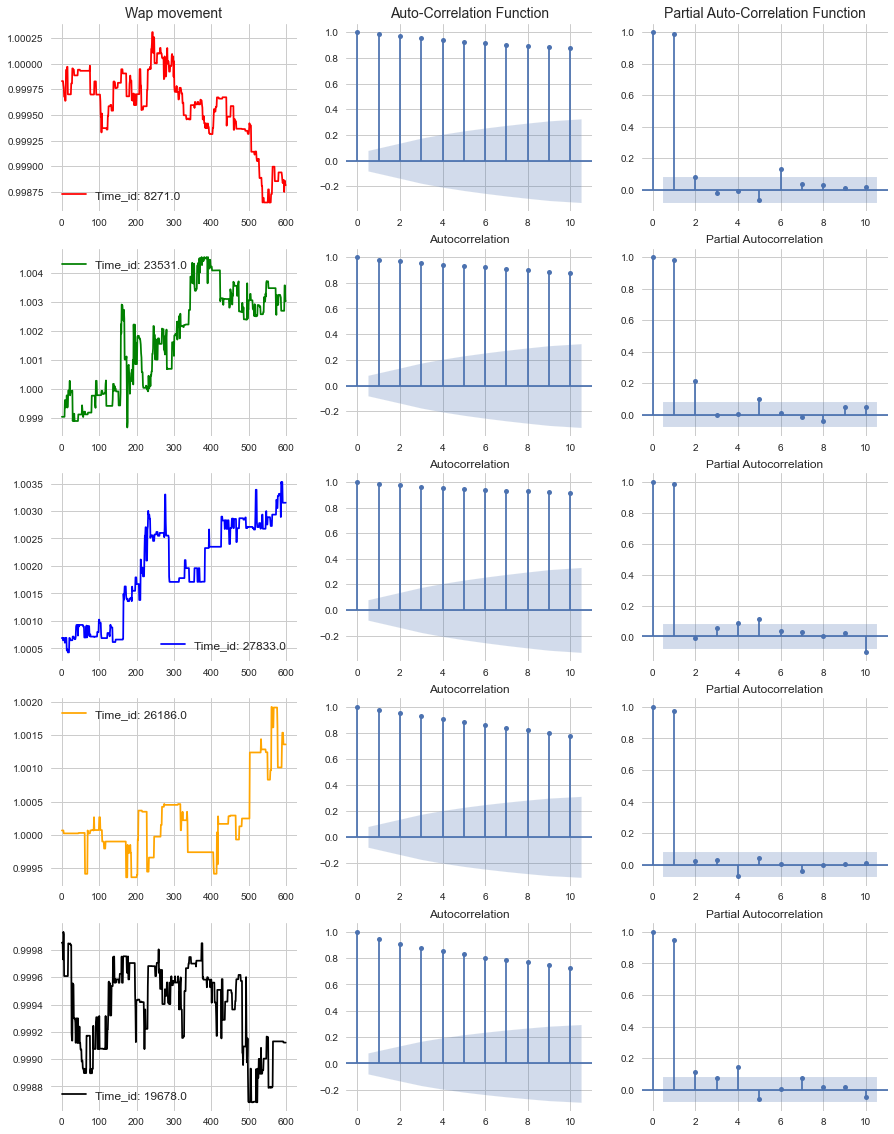

In [596]:
import random

fig, axes = plt.subplots(5,3, figsize = (15,20))

colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange', 4:'black'}

for i, time_id in enumerate(time_ids):
    
    ax = axes.flatten()[i*3]
    ax.plot(np.arange(0,600), book[book['time_id'] == time_id]['wap'], label = "Time_id: "+str(time_id), c= colors[i])
    ax.legend(fontsize=12)
    
    ax1 = axes.flatten()[i*3+1]
    plot_acf(book[book['time_id'] == time_id]['wap'], alpha=0.05, lags = 10, ax = ax1)
    
    ax2 = axes.flatten()[i*3+2]
    plot_pacf(book[book['time_id'] == time_id]['wap'], alpha=0.05, lags = 10, ax = ax2)
    
    if i==0:
        ax.set_title('Wap movement', fontsize=14)
        ax1.set_title("Auto-Correlation Function", fontsize=14)
        ax2.set_title("Partial Auto-Correlation Function", fontsize=14)
        
plt.show()

**Observation**: The above graphs show that the ACF trails off, while the PACF cuts off after 1 or 2 lags. So the WAP movement could be modelled with an AR(1) or AR(2) models.

### Features developed for book file

1) **abs_speed_book**: This is the absolute speed of price(wap) movement. It is like return, but has a time element to it. Simply, it is the price change divided by time taken for the price change. We take the absolute value. 

2) **abs_acceleration_book**: This is the absolute acceleration of price(wap) movement. Simply, it is the change in speed divided by time taken.

3) **hl_index_book**: This is the **highest** price during the time_id divided by the **lowest** price during that time_id. It gives a sense of the total swing in price during a given time_id.

4) **clop_index_book**: This is the **closing** price of a given time_id divided by the **opening** for that time_id. It gives a sense of net change in price during a given time_id.

5) **realized_vol_book**: This is realized volatility of the price during the given time_id. It is derived using the formula provided by Optiver. It is the square root of the sum total of squared log returns.


In [381]:
book_features = features_from_book(book)
book_features.head()

,stock_id,time_id,abs_speed_book,abs_acceleration_book,hl_index_book,clop_index_book,realized_vol_book
0,0,5.0,0.046769,0.087491,1.003481,1.002294,0.004499
1,0,11.0,0.007391,0.014237,1.001135,1.000360,0.001204
2,0,16.0,0.016550,0.031284,1.003665,0.997928,0.002369
3,0,31.0,0.011988,0.023553,1.002972,0.997176,0.002574
4,0,62.0,0.011892,0.023111,1.000928,0.999998,0.001895


Now let's look at the trade file. 

## Trade File

In [587]:
trade = pd.read_csv('../WIP_data/trade/train/stock_0_trade_train.csv')
trade.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002819,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [264]:
trade.shape

(99116, 6)

Sometimes, the 1st trade doesn't happen at '0' second. As such, the price change for this trade cannot be ascertained.

To be able to calculate the trade price change, we can initialize the trade price to wap in the second immediately before
the first trade. For e.g. in the below table the trade price for 'seconds_in_bucket = 20' is set equal to the wap price of 1.001443. The wap price is picked up from the book of this stock for the same time_id. There is no other data such as size, order_count etc. for this second and as such we leave those fields blank.


In [588]:


trade = initialize_trade_price(trade, book)
trade.head()

,seconds_in_bucket,time_id,price,size,order_count,stock_id
0,20,5.0,1.001443,NaN,NaN,NaN
1,21,5.0,1.002301,326.0,12.0,0.0
2,46,5.0,1.002778,128.0,4.0,0.0
3,50,5.0,1.002819,55.0,1.0,0.0
4,57,5.0,1.003155,121.0,5.0,0.0


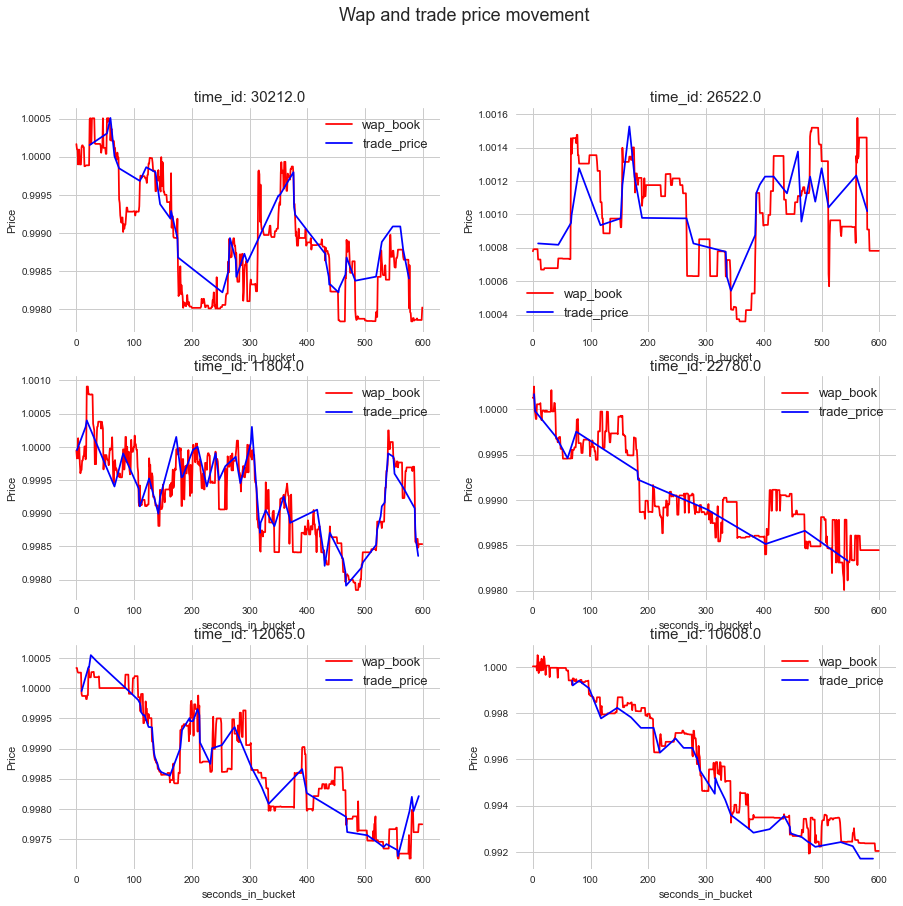

In [604]:
# Let's do a visualization to see how the trade price and wap(from book) move in the same time buckets

fig, axes = plt.subplots(3,2, figsize = (15,14))
time_ids = random.sample(sorted(book['time_id'].unique()), 6)

colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange', 4:'black'}


for i, time_id in enumerate(time_ids):
    
    ax = axes.flatten()[i]
    ax.plot(np.arange(0,600), book[book['time_id'] == time_id]['wap'], label = "wap_book", c= 'red')
    ax.plot(trade[trade['time_id'] == time_id]['seconds_in_bucket'], trade[trade['time_id'] == time_id]['price'], \
            label = "trade_price", c= 'blue')
    ax.set_ylabel('Price')
    ax.set_xlabel('seconds_in_bucket')
    ax.set_title('time_id: '+str(time_id), fontsize=15)
    ax.legend(fontsize=13)

plt.suptitle('Wap and trade price movement', fontsize=18)
plt.show()

**Observation:** From the charts above, it is clear that wap and trade price closely track each other. However, it is difficult to say which one drives the other. 

Now let's derive a few features using the trade file and then visualize how these trade features and some of the book features derived earlier are distributed. 

### Features developed for trade file

1) **abs_speed_trade**: This is the absolute speed of price movement in trade file. It is like return, but has a time element to it. Simply, it is the price change divided by time taken for the price change. We take the absolute value. 

2) **abs_acceleration_trade**: This is the absolute acceleration of price movement. Simply, it is the change in speed divided by time taken.

3) **hl_index_trade**: This is the **highest** price during the time_id divided by the **lowest** price during that time_id. It gives a sense of the total swing in traded price during a given time_id.

4) **clop_index_trade**: This is the **closing** price of a given time_id divided by the **opening** for that time_id. It gives a sense of net change in price during a given time_id.

5) **realized_vol_trade**: This is realized volatility of the traded price during the given time_id. It is derived using the formula provided by Optiver.

6) **turnover**: This is the total value of stocks traded in a given time_id. It is the price multiplied with size (no. of shares traded). 

7) **size**: This is the total no. of stocks traded in a given time_id. 

8) **order_count**: This is the total no. of orders executed in a given time_id.

9) **momentum**: Using a concept derived from physics, this is the **mass * velocity**. Mass here is taken as no. of shares traded, and velocity is the 'abs_speed_trade** as defined above. The momentum for a time_id is the sum total of momentum for each trade executed during the time_id. 

10) **abs_force_trade**: Using a concept derived from physics, this is the **mass * acceleration**. Mass here is taken as no. of shares traded, and acceleration is the 'abs_acceleration_trade** as defined above. The abs_force_trade for a time_id is the sum total of 'abs_force_trade' for each trade executed during the time_id. 


In [589]:

trade = trade_params(trade)
trade.head()

,seconds_in_bucket,time_id,price,size,order_count,stock_id,log_return,turnover,abs_speed_trade,abs_acceleration_trade,momentum,abs_force_trade
1,21,5.0,1.002301,326.0,12.0,0.0,0.000857,326.750224,0.000859,8.586558e-04,0.279922,0.279922
2,46,5.0,1.002778,128.0,4.0,0.0,0.000475,128.355584,0.000019,3.358351e-05,0.002441,0.004299
3,50,5.0,1.002819,55.0,1.0,0.0,0.000040,55.155017,0.000010,2.235750e-06,0.000557,0.000123
4,57,5.0,1.003155,121.0,5.0,0.0,0.000336,121.381803,0.000048,5.429082e-06,0.005824,0.000657
5,68,5.0,1.003646,4.0,1.0,0.0,0.000489,4.014584,0.000045,3.216057e-07,0.000178,0.000001


In [385]:
trade_features = features_from_trade(trade)
trade_features.head()

,time_id,turnover,size,order_count,abs_speed_trade,abs_acceleration_trade,momentum,abs_force_trade,hl_index_trade,clop_index_trade,realized_vol_trade
0,5.0,3190.139198,3179.0,110.0,0.002680,0.001734,0.443241,0.344239,1.002374,1.001342,0.002181
1,11.0,1287.353777,1287.0,55.0,0.000546,0.000226,0.054988,0.021759,1.001104,1.000703,0.000901
2,16.0,2158.608951,2161.0,68.0,0.001379,0.000852,0.127383,0.061771,1.003072,0.997464,0.001964
3,31.0,1959.605540,1962.0,59.0,0.000638,0.000442,0.050882,0.032270,1.002264,0.997741,0.001563
4,62.0,1790.254510,1791.0,89.0,0.000434,0.000264,0.013473,0.002078,1.000793,0.999726,0.000876


In [386]:
# We merge the book and trade features into one file and also add the target from the train file to this dataframe

all_features = book_features.merge(trade_features, on='time_id', how='left')
all_features.head()

,stock_id,time_id,abs_speed_book,abs_acceleration_book,hl_index_book,clop_index_book,realized_vol_book,turnover,size,order_count,abs_speed_trade,abs_acceleration_trade,momentum,abs_force_trade,hl_index_trade,clop_index_trade,realized_vol_trade
0,0,5.0,0.046769,0.087491,1.003481,1.002294,0.004499,3190.139198,3179.0,110.0,0.002680,0.001734,0.443241,0.344239,1.002374,1.001342,0.002181
1,0,11.0,0.007391,0.014237,1.001135,1.000360,0.001204,1287.353777,1287.0,55.0,0.000546,0.000226,0.054988,0.021759,1.001104,1.000703,0.000901
2,0,16.0,0.016550,0.031284,1.003665,0.997928,0.002369,2158.608951,2161.0,68.0,0.001379,0.000852,0.127383,0.061771,1.003072,0.997464,0.001964
3,0,31.0,0.011988,0.023553,1.002972,0.997176,0.002574,1959.605540,1962.0,59.0,0.000638,0.000442,0.050882,0.032270,1.002264,0.997741,0.001563
4,0,62.0,0.011892,0.023111,1.000928,0.999998,0.001895,1790.254510,1791.0,89.0,0.000434,0.000264,0.013473,0.002078,1.000793,0.999726,0.000876


In [387]:
target = pd.read_csv('../WIP_data/target_training_data.csv')
target_stk = target[target['stock_id'] == 0][['time_id', 'target']]
target_stk.head()

,time_id,target
0,5,0.004136
1,11,0.001445
2,16,0.002168
3,31,0.002195
4,62,0.001747


In [388]:
all_features = all_features.merge(target_stk, on='time_id', how='left')
all_features.head()

,stock_id,time_id,abs_speed_book,abs_acceleration_book,hl_index_book,clop_index_book,realized_vol_book,turnover,size,order_count,abs_speed_trade,abs_acceleration_trade,momentum,abs_force_trade,hl_index_trade,clop_index_trade,realized_vol_trade,target
0,0,5.0,0.046769,0.087491,1.003481,1.002294,0.004499,3190.139198,3179.0,110.0,0.002680,0.001734,0.443241,0.344239,1.002374,1.001342,0.002181,0.004136
1,0,11.0,0.007391,0.014237,1.001135,1.000360,0.001204,1287.353777,1287.0,55.0,0.000546,0.000226,0.054988,0.021759,1.001104,1.000703,0.000901,0.001445
2,0,16.0,0.016550,0.031284,1.003665,0.997928,0.002369,2158.608951,2161.0,68.0,0.001379,0.000852,0.127383,0.061771,1.003072,0.997464,0.001964,0.002168
3,0,31.0,0.011988,0.023553,1.002972,0.997176,0.002574,1959.605540,1962.0,59.0,0.000638,0.000442,0.050882,0.032270,1.002264,0.997741,0.001563,0.002195
4,0,62.0,0.011892,0.023111,1.000928,0.999998,0.001895,1790.254510,1791.0,89.0,0.000434,0.000264,0.013473,0.002078,1.000793,0.999726,0.000876,0.001747


## Distribution of Key Features

Let's us visualize the density plots of some of the features to understand how they are distributed.


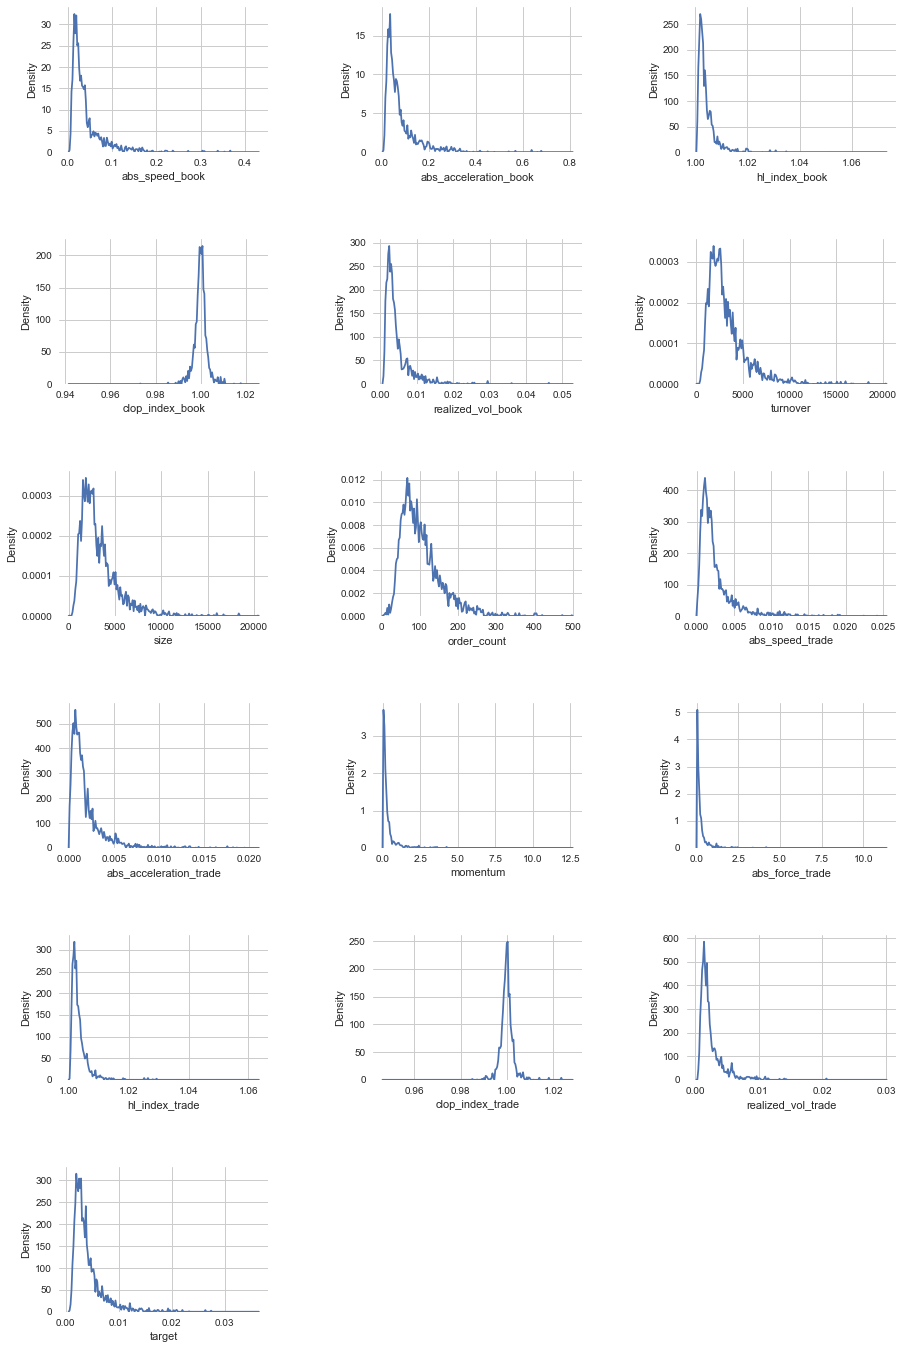

In [603]:
sns.set_style('whitegrid')
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id']]
densityplots(all_features[all_features['stock_id'] ==0], features, ncol=3, figsize=(15, 24))

**Key Observations:**
* Many of the distributions are right tailed and understandably so. This is since for many features like abs_speed, realized_vol, we are taking absolute changes or squaring log_return for example.

* Some features have very high density around the central value e.g. realized_vol (both book and trade), high-low index(hl_index), the target etc.


Let's use the qq-plot to check whether these distributions are normal or not.


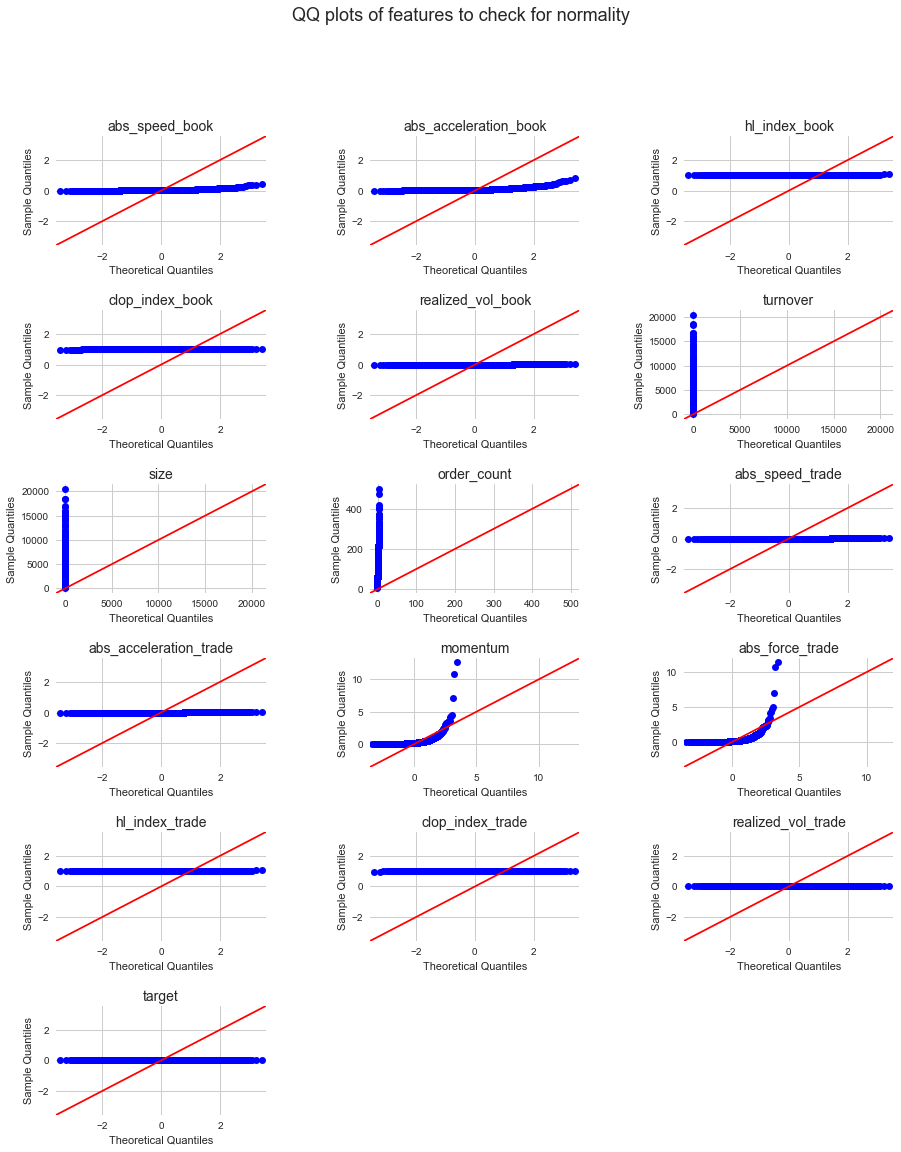

In [624]:
qqplots(all_features[all_features['stock_id'] ==0], features, ncol=3, figsize=(15, 18))

The qqplots show that the distributions are **not normal**. Let's confirm this using the Kolmogorov Smirnov test.


In [637]:
my_data = norm.rvs(size=1000)
for feature in features:
    ks_statistic, p_value = kstest(all_features[all_features['stock_id'] ==0][feature], 'norm')
    print(f'feature: {feature} --> p-value of KS test = {p_value:4.4f}')


feature: abs_speed_book --> p-value of KS test = 0.0000
feature: abs_acceleration_book --> p-value of KS test = 0.0000
feature: hl_index_book --> p-value of KS test = 0.0000
feature: clop_index_book --> p-value of KS test = 0.0000
feature: realized_vol_book --> p-value of KS test = 0.0000
feature: turnover --> p-value of KS test = 0.0000
feature: size --> p-value of KS test = 0.0000
feature: order_count --> p-value of KS test = 0.0000
feature: abs_speed_trade --> p-value of KS test = 0.0000
feature: abs_acceleration_trade --> p-value of KS test = 0.0000
feature: momentum --> p-value of KS test = 0.0000
feature: abs_force_trade --> p-value of KS test = 0.0000
feature: hl_index_trade --> p-value of KS test = 0.0000
feature: clop_index_trade --> p-value of KS test = 0.0000
feature: realized_vol_trade --> p-value of KS test = 0.0000
feature: target --> p-value of KS test = 0.0000


The p-value for all features is below 0.05, in fact it is 0.0. So we do not assume normal distribution.

For stock_id = 0, let's plot the correlations matrix for each of the above defined features and the target. Remember, the **target** is the realized volatility in wap price for the **10 minutes following the period** for which we are given the data. 


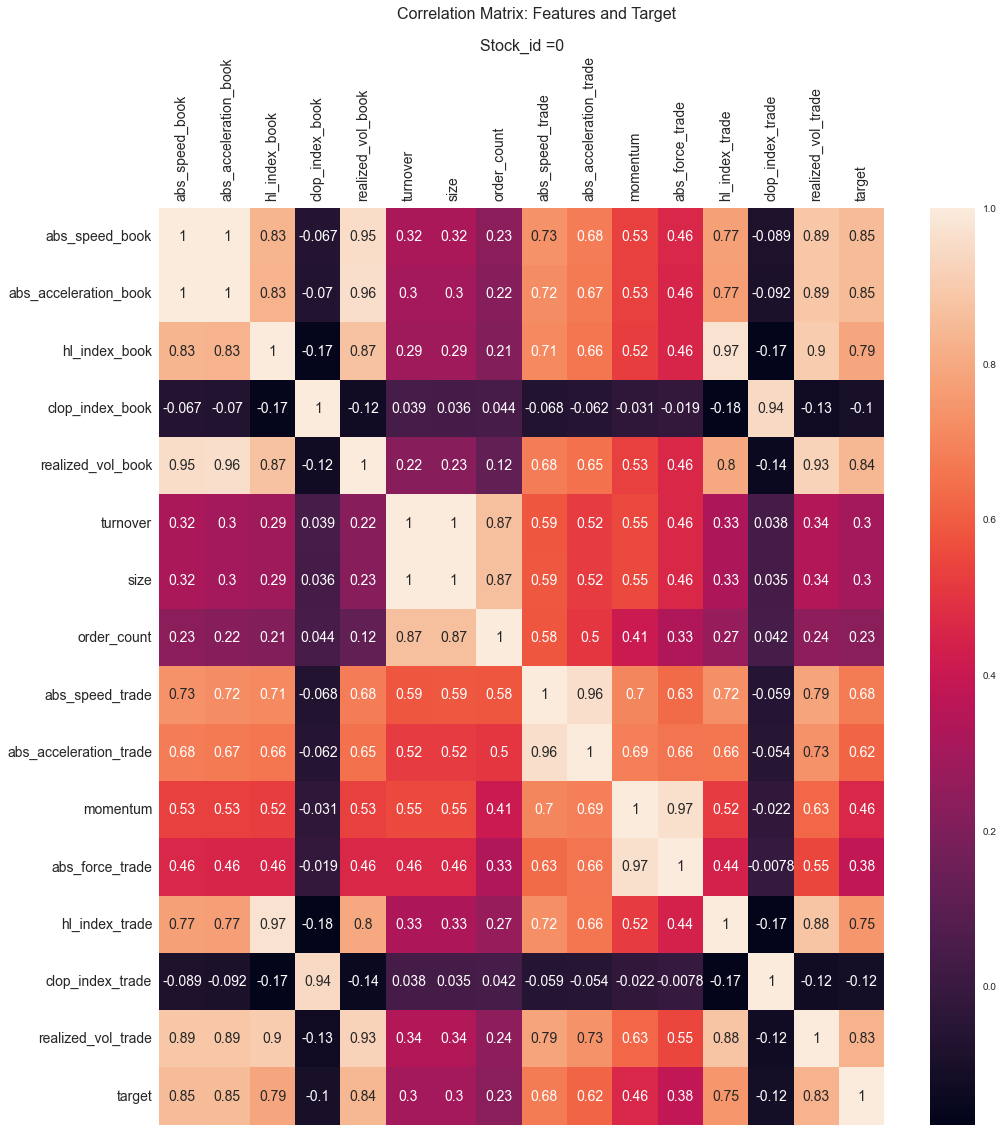

In [393]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(15,16))
ax=sns.heatmap(all_features.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":14})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id =" +str(all_features.stock_id.unique()[0]), fontsize=16)
plt.tight_layout()
plt.show()


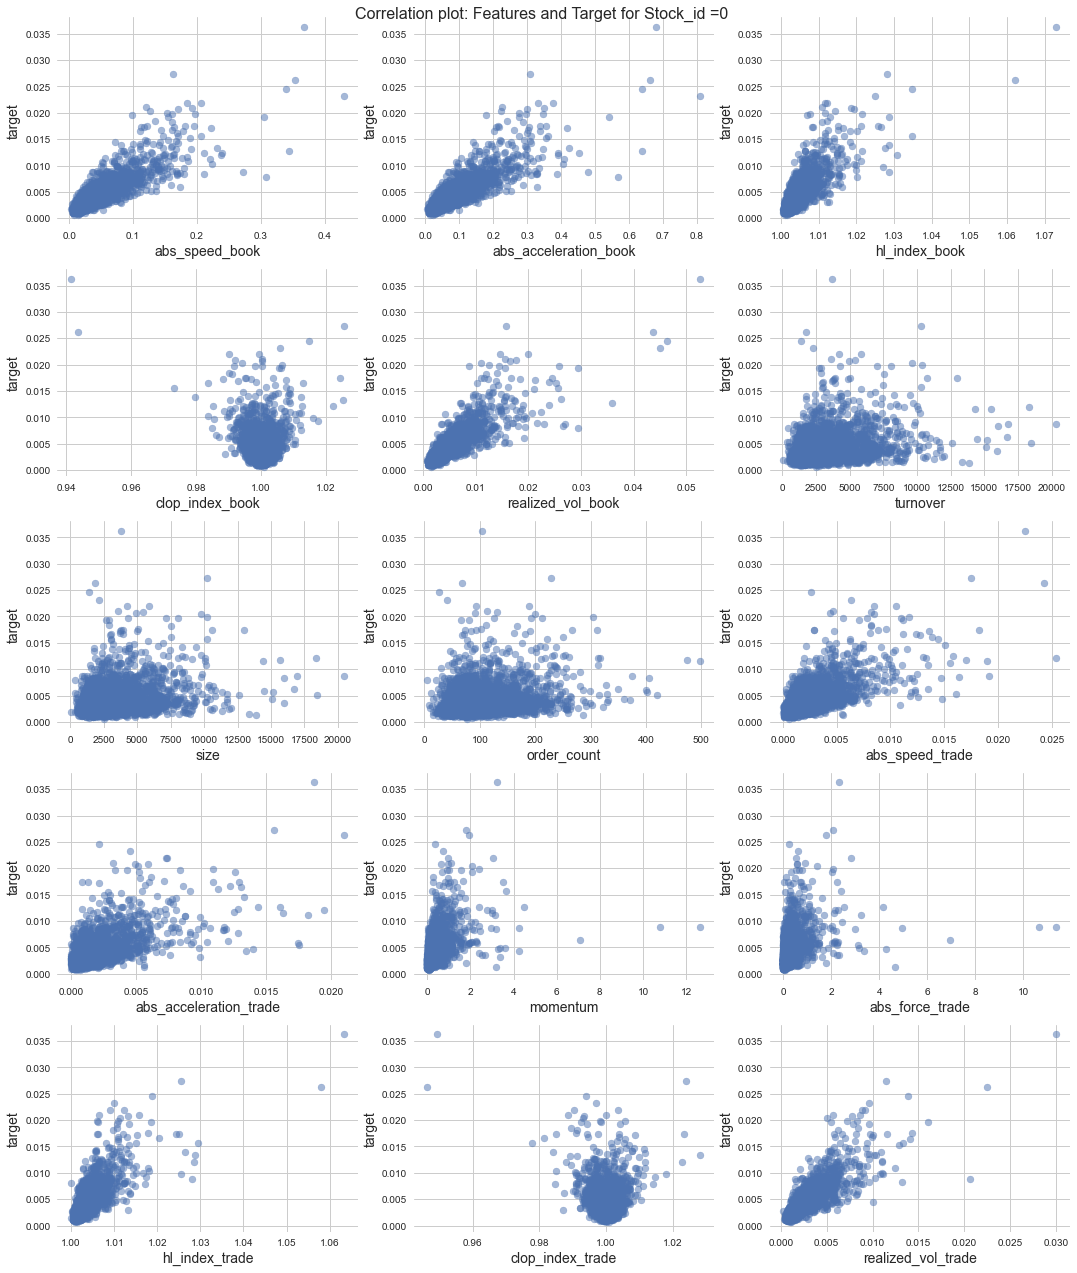

In [407]:
sns.set_style('whitegrid')
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id', 'target']]
scatterplots(all_features, features, 'target', ncol=3, figsize=(15, 18))

**Key Observation from Correlation plots for stock_id = 0**

1. The top features that have significant correlations (based on the Pearson Correlation Coefficient) with the target are:

    * **abs_speed_book** : 0.85
    * **abs_acceleration_book**: 0.85
    * **realized_volatility_book**: 0.84
    * **realized_volatility_trade**: 0.83
    * **hl_index_book**: 0.79
    * **hl_index_trade**: 0.75
    

## Is the volatility of stocks correlated?

Some others questions for which it would interesting to find answers in the exploratory analysis are:

   * **How is volatility of different stocks connected ? Are there clusters of stocks with similar volatility levels?**
   * **How is an individual stock's volatility connected to the market's overall volatility ?** 

Let's try to answers these questions now. For the purpose of this analysis, we shall randomly select **30 stocks** from the 112 stocks.


In [428]:
import random

file_list = glob.glob('../Raw_data/book_train.parquet/stock_id=*')

stock_ids = [int(filename.split('=')[1]) for filename in file_list]

stocks_30 = random.sample(stock_ids, 30)

In [434]:

all_features = pd.DataFrame()

for stock_id in stocks_30:
    book_file = "../WIP_data/book/train/stock_"+str(stock_id)+"_book_train.csv"
    trade_file = "../WIP_data/trade/train/stock_"+str(stock_id)+"_trade_train.csv"
    
    book = pd.read_csv(book_file)
    trade = pd.read_csv(trade_file)
    
    book = book_params(book)
    book_features = features_from_book(book)
    
    trade = initialize_trade_price(trade, book)
    trade = trade_params(trade)
    trade_features = features_from_trade(trade)
    
    all_features_new = book_features.merge(trade_features, on='time_id', how='left')
    target_stk = target[target['stock_id'] == stock_id][['time_id', 'target']]
    all_features_new = all_features_new.merge(target_stk, on='time_id', how='left')
    
    all_features = pd.concat([all_features, all_features_new], ignore_index=True)
    
    
    

In [435]:
all_features.head()

,stock_id,time_id,abs_speed_book,abs_acceleration_book,hl_index_book,clop_index_book,realized_vol_book,turnover,size,order_count,abs_speed_trade,abs_acceleration_trade,momentum,abs_force_trade,hl_index_trade,clop_index_trade,realized_vol_trade,target
0,41,5.0,0.026161,0.043898,1.002797,1.000685,0.001997,61839.793713,61738.0,466.0,0.002764,0.002115,2.392969,1.398003,1.002674,1.000668,0.001347,0.002184
1,41,11.0,0.007426,0.013091,1.001303,1.000608,0.000901,43319.609619,43293.0,379.0,0.000859,0.000695,1.512866,1.163004,1.001230,1.000615,0.000810,0.000652
2,41,16.0,0.021184,0.034841,1.002339,0.998842,0.001540,31817.914888,31839.0,312.0,0.003209,0.002397,1.455099,1.115874,1.002370,0.998709,0.001382,0.001774
3,41,31.0,0.009947,0.017213,1.001335,0.999243,0.001127,34860.666440,34898.0,279.0,0.000525,0.000206,0.593284,0.173273,1.001337,0.999110,0.001033,0.000841
4,41,62.0,0.010449,0.018401,1.001212,1.000185,0.001148,21622.144369,21619.0,226.0,0.000631,0.000455,0.692065,0.506941,1.001118,1.000000,0.000885,0.001509


In [438]:
save_file(all_features, '30_stock_features.csv', datapath)


Writing file.  "../WIP_data/features\30_stock_features.csv"


In [446]:
realized_vol = all_features.pivot_table(index='time_id', columns = 'stock_id', values = 'realized_vol_book').reset_index()
realized_vol.columns = ['stock_'+str(col) if col != 'time_id' else col for col in realized_vol.columns]
realized_vol.head()

,time_id,stock_1,stock_4,stock_5,stock_8,stock_14,stock_22,stock_26,stock_34,stock_35,...,stock_95,stock_99,stock_101,stock_102,stock_103,stock_104,stock_108,stock_110,stock_116,stock_126
0,5.0,0.006245,0.005640,0.005366,0.009680,0.002237,0.004934,0.003899,0.002553,0.003079,...,0.004168,0.002085,0.005351,0.006935,0.005832,0.003629,0.002976,0.005126,0.009201,0.007255
1,11.0,0.002305,0.002037,0.001776,0.003838,0.001132,0.002106,0.001349,0.001288,0.001654,...,0.001606,0.001024,0.002536,0.001705,0.001986,0.001366,0.001174,0.003623,0.002097,0.003294
2,16.0,0.002517,0.002709,0.002458,0.001580,0.002311,0.003028,0.001790,0.001520,0.001993,...,0.001834,0.001888,0.002198,0.002623,0.002314,0.002908,0.002395,0.002230,0.002270,0.002719
3,31.0,0.003570,0.002182,0.004464,0.003800,0.001712,0.002583,0.001963,0.001345,0.002155,...,0.001881,0.001481,0.004751,0.001823,0.001689,0.002152,0.001914,0.003695,0.003180,0.004418
4,62.0,0.002903,0.002710,0.002807,0.005626,0.001222,0.001856,0.001197,0.001087,0.002239,...,0.001627,0.000995,0.002789,0.002034,0.002164,0.000687,0.001695,0.003175,0.003445,0.002538


In [483]:
realized_vol.shape

(3064, 32)

In [484]:
realized_vol.dropna(how='any', inplace=True)
realized_vol.shape

(3054, 32)

In [485]:
realized_vol['market_average'] = realized_vol.drop(columns = ['time_id']).mean(axis=1)
realized_vol.head()

,time_id,stock_1,stock_4,stock_5,stock_8,stock_14,stock_22,stock_26,stock_34,stock_35,...,stock_99,stock_101,stock_102,stock_103,stock_104,stock_108,stock_110,stock_116,stock_126,market_average
0,5.0,0.006245,0.005640,0.005366,0.009680,0.002237,0.004934,0.003899,0.002553,0.003079,...,0.002085,0.005351,0.006935,0.005832,0.003629,0.002976,0.005126,0.009201,0.007255,0.004697
1,11.0,0.002305,0.002037,0.001776,0.003838,0.001132,0.002106,0.001349,0.001288,0.001654,...,0.001024,0.002536,0.001705,0.001986,0.001366,0.001174,0.003623,0.002097,0.003294,0.002158
2,16.0,0.002517,0.002709,0.002458,0.001580,0.002311,0.003028,0.001790,0.001520,0.001993,...,0.001888,0.002198,0.002623,0.002314,0.002908,0.002395,0.002230,0.002270,0.002719,0.002249
3,31.0,0.003570,0.002182,0.004464,0.003800,0.001712,0.002583,0.001963,0.001345,0.002155,...,0.001481,0.004751,0.001823,0.001689,0.002152,0.001914,0.003695,0.003180,0.004418,0.002729
4,62.0,0.002903,0.002710,0.002807,0.005626,0.001222,0.001856,0.001197,0.001087,0.002239,...,0.000995,0.002789,0.002034,0.002164,0.000687,0.001695,0.003175,0.003445,0.002538,0.002228


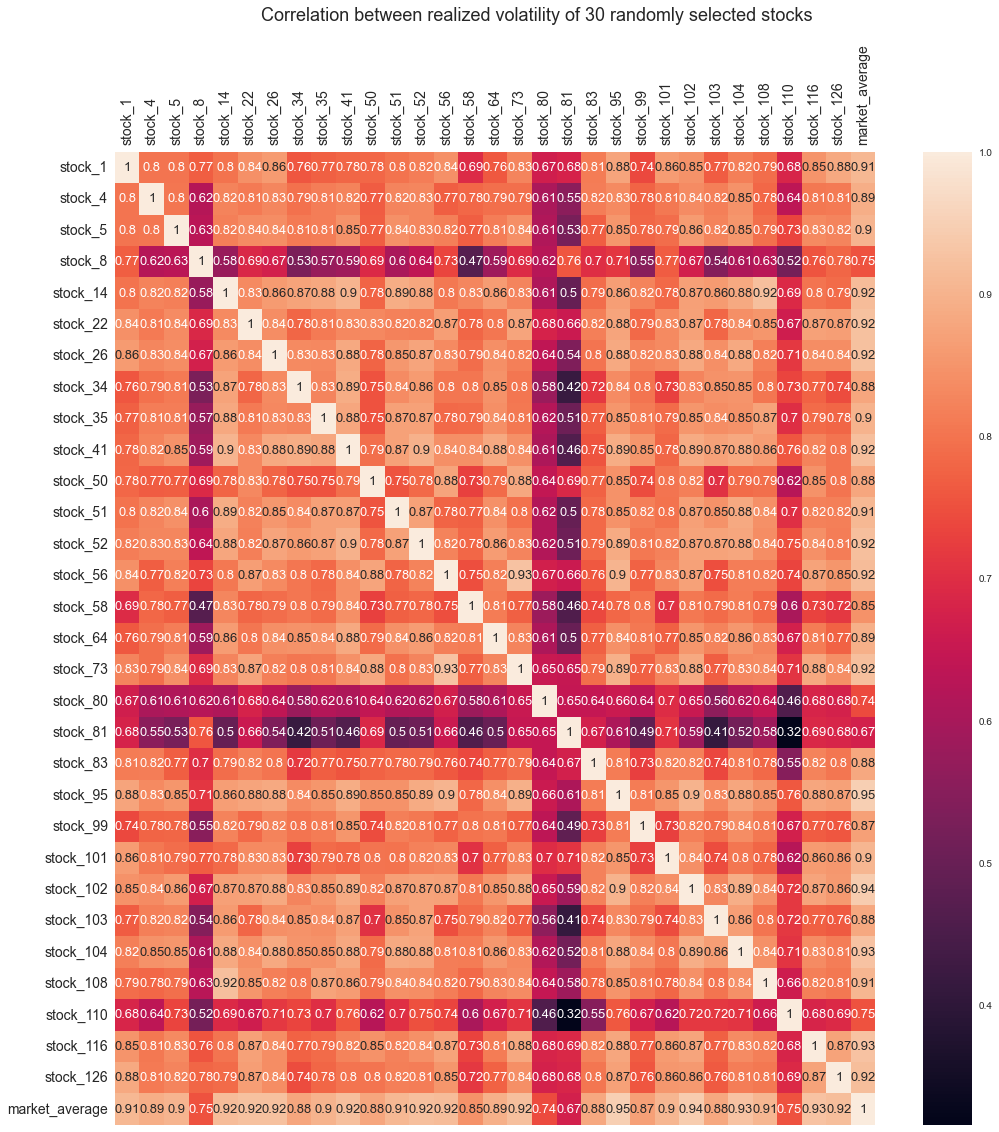

In [486]:

sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(15,16))
ax=sns.heatmap(realized_vol.drop(['time_id'], axis=1).corr(), annot=True, annot_kws={"size":13})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation between realized volatility of 30 randomly selected stocks\n", fontsize=18)
#plt.title("Stock_id =" +str(all_features_23.stock_id.unique()[0]), fontsize=16)
plt.tight_layout()
plt.show()


We can see that the volatility of many stocks has high degree of correlation, upwards of 0.8. There are only a handful of stocks that stand out with low correlations, namely stock_8, stock_80, stock_81 and stock_110.


## Are there clusters amongst the 112 stocks that behave similarly on certain parameters?

The correlation heatmap for realized volatility of stocks indicated that many stocks behave similarly on this paramter. 
Let's do a clustering analysis to find if there are clusters of stocks. To do this, we will do the clustering analysis for each feature separately. The input to the clustering algorithm would be the feature values across all time_ids for each of the 112 stocks.


In [496]:
import random

file_list = glob.glob('../Raw_data/book_train.parquet/stock_id=*')

stock_ids = [int(filename.split('=')[1]) for filename in file_list]

all_features = pd.DataFrame()

for stock_id in stock_ids:
    book_file = "../WIP_data/book/train/stock_"+str(stock_id)+"_book_train.csv"
    trade_file = "../WIP_data/trade/train/stock_"+str(stock_id)+"_trade_train.csv"
    
    book = pd.read_csv(book_file)
    trade = pd.read_csv(trade_file)
    
    book = book_params(book)
    book_features = features_from_book(book)
    
    trade = initialize_trade_price(trade, book)
    trade = trade_params(trade)
    trade_features = features_from_trade(trade)
    
    all_features_new = book_features.merge(trade_features, on='time_id', how='left')
    target_stk = target[target['stock_id'] == stock_id][['time_id', 'target']]
    all_features_new = all_features_new.merge(target_stk, on='time_id', how='left')
    
    all_features = pd.concat([all_features, all_features_new], ignore_index=True)

save_file(all_features, 'all_stock_features.csv', datapath)

Writing file.  "../WIP_data/features\all_stock_features.csv"


In [497]:
all_features.head()

,stock_id,time_id,abs_speed_book,abs_acceleration_book,hl_index_book,clop_index_book,realized_vol_book,turnover,size,order_count,abs_speed_trade,abs_acceleration_trade,momentum,abs_force_trade,hl_index_trade,clop_index_trade,realized_vol_trade,target
0,0,5.0,0.046769,0.087491,1.003481,1.002294,0.004499,3190.139198,3179.0,110.0,0.002680,0.001734,0.443241,0.344239,1.002374,1.001342,0.002181,0.004136
1,0,11.0,0.007391,0.014237,1.001135,1.000360,0.001204,1287.353777,1287.0,55.0,0.000546,0.000226,0.054988,0.021759,1.001104,1.000703,0.000901,0.001445
2,0,16.0,0.016550,0.031284,1.003665,0.997928,0.002369,2158.608951,2161.0,68.0,0.001379,0.000852,0.127383,0.061771,1.003072,0.997464,0.001964,0.002168
3,0,31.0,0.011988,0.023553,1.002972,0.997176,0.002574,1959.605540,1962.0,59.0,0.000638,0.000442,0.050882,0.032270,1.002264,0.997741,0.001563,0.002195
4,0,62.0,0.011892,0.023111,1.000928,0.999998,0.001895,1790.254510,1791.0,89.0,0.000434,0.000264,0.013473,0.002078,1.000793,0.999726,0.000876,0.001747


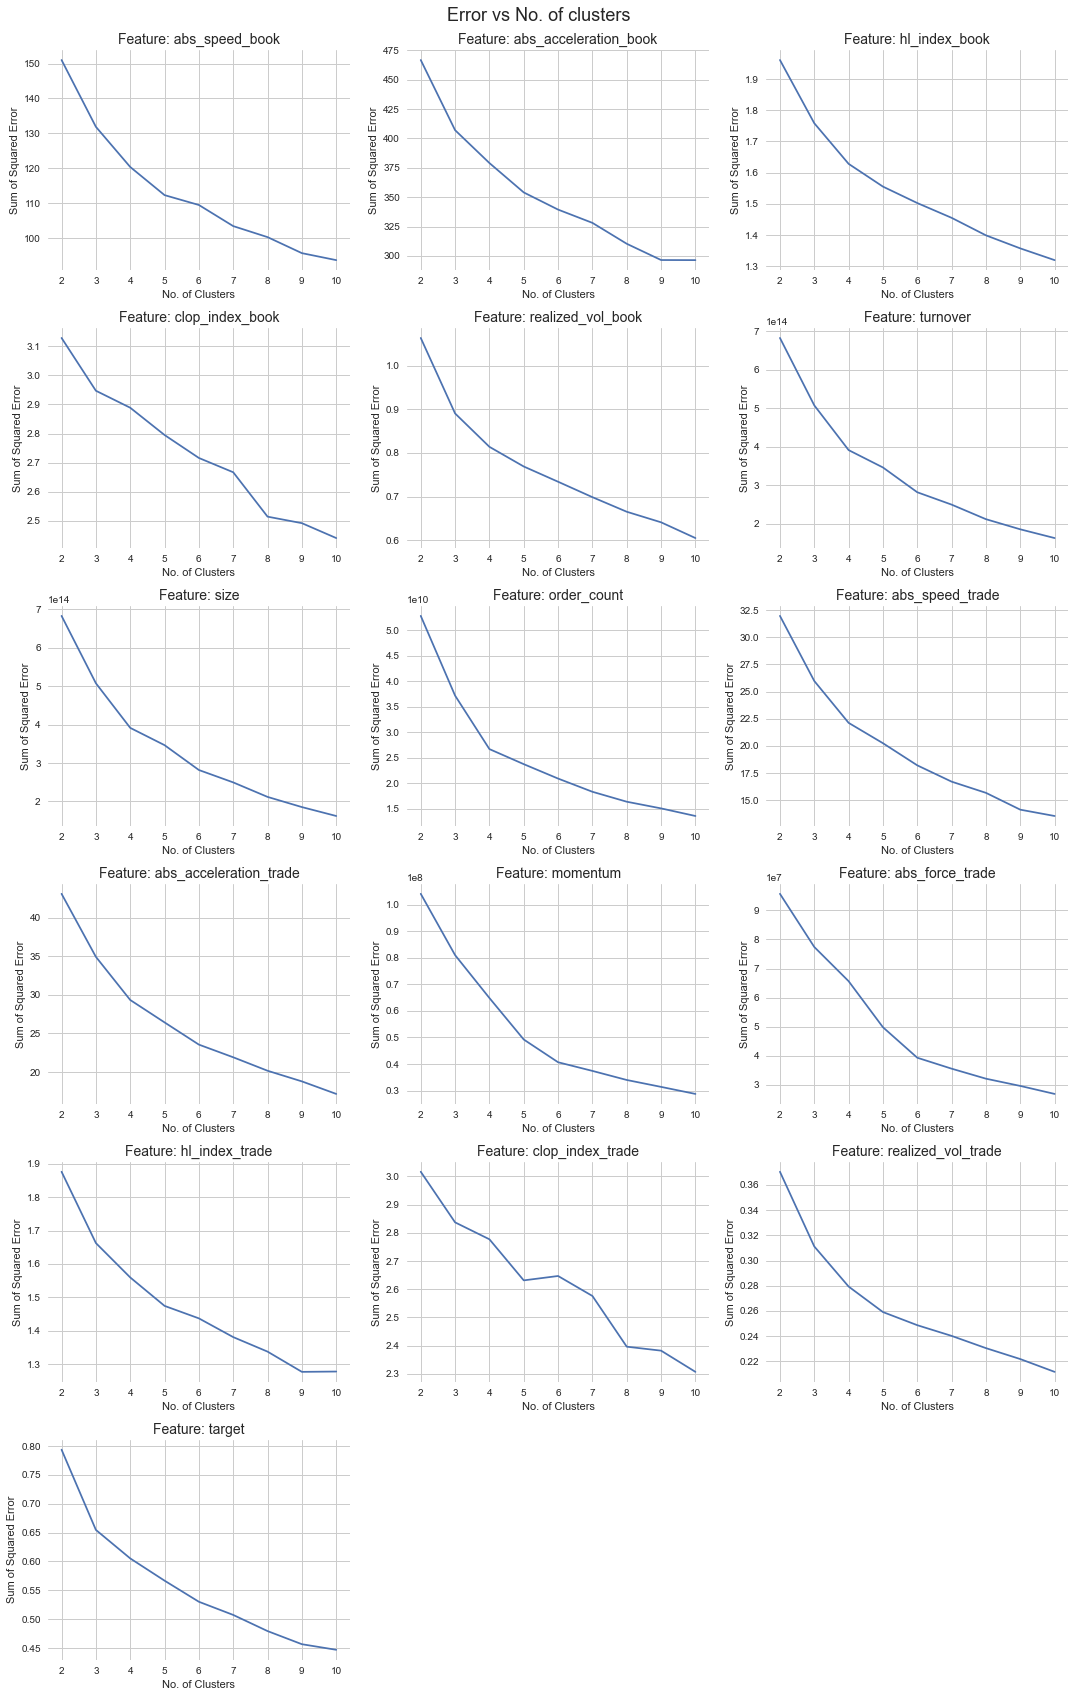

In [515]:
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id']]

plot_cluster_sse(all_features, features, ncols=3, figsize=(15,24))


On most of the features, the elbow is between 3 to 5 clusters. Let's plot 4 clusters and visualize the output.


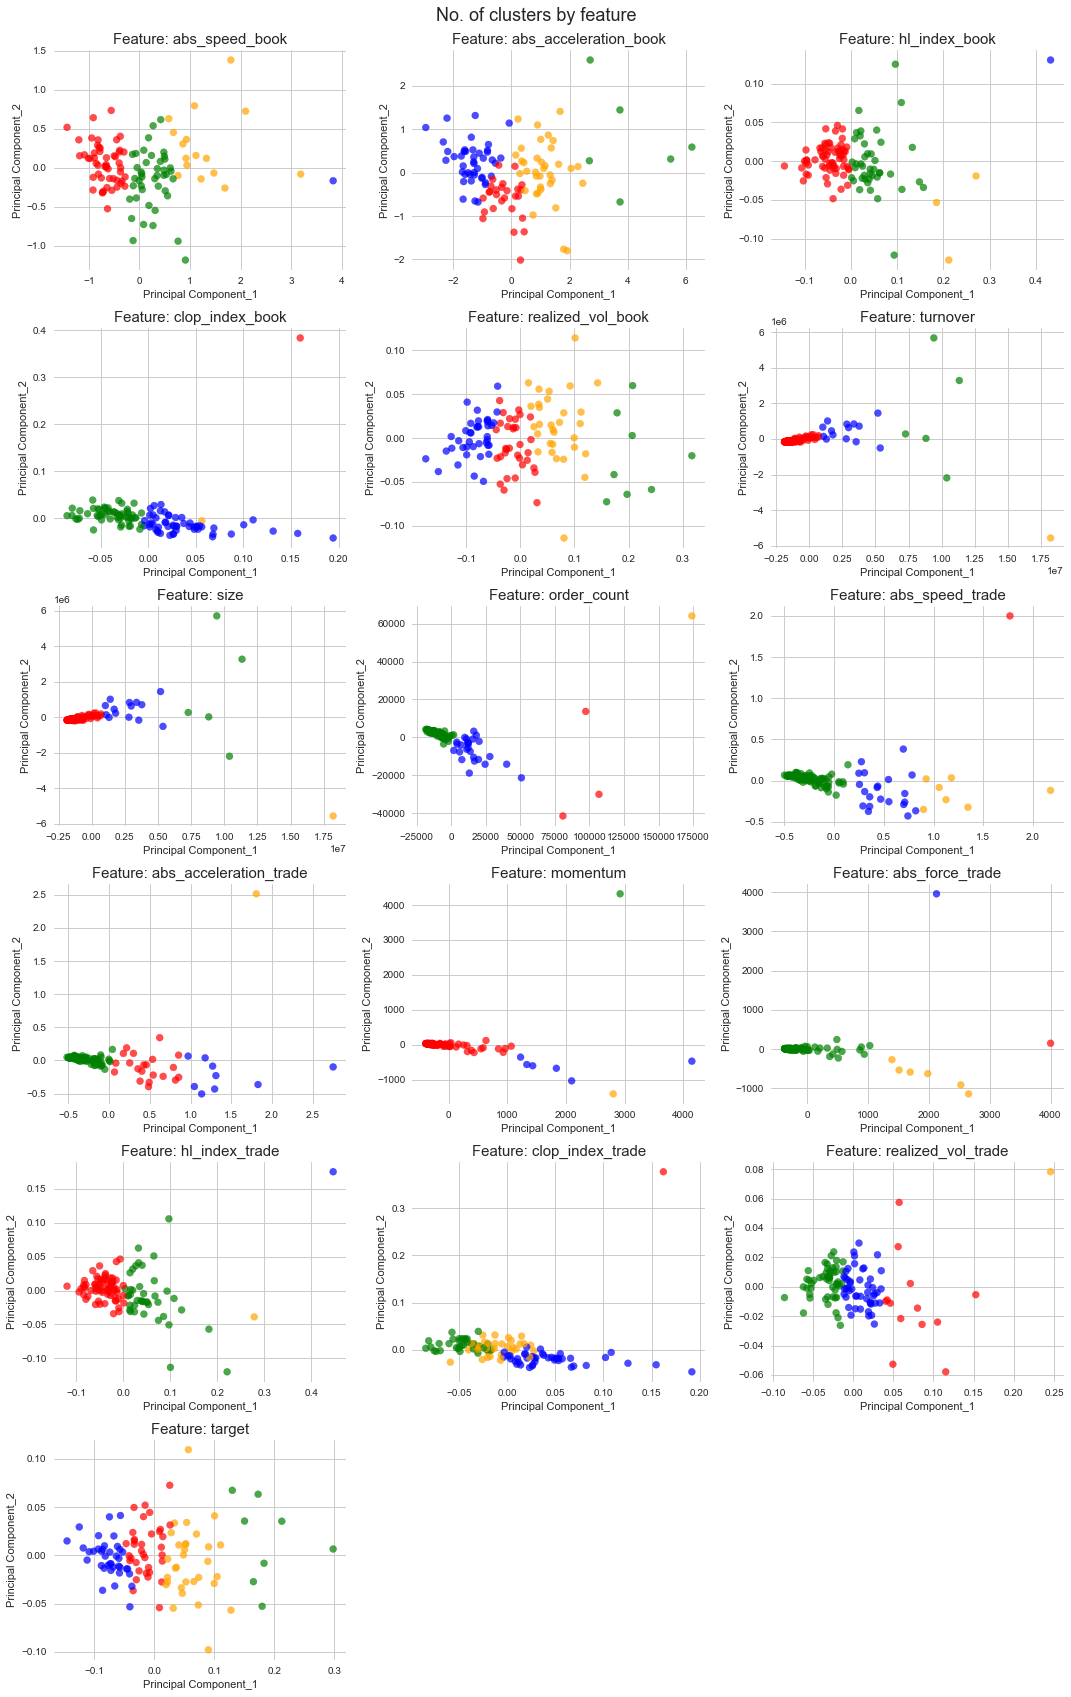

In [642]:
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id']]

plot_clusters(all_features, features, nclusters = 4, ncols=3, figsize=(15,24))

Visually, it seems like on key features such as realized volatility, hl_index, abs_speed etc. there is one large central cluster and then many outliers. Let's plot 3 clusters and see if that looks more practical.


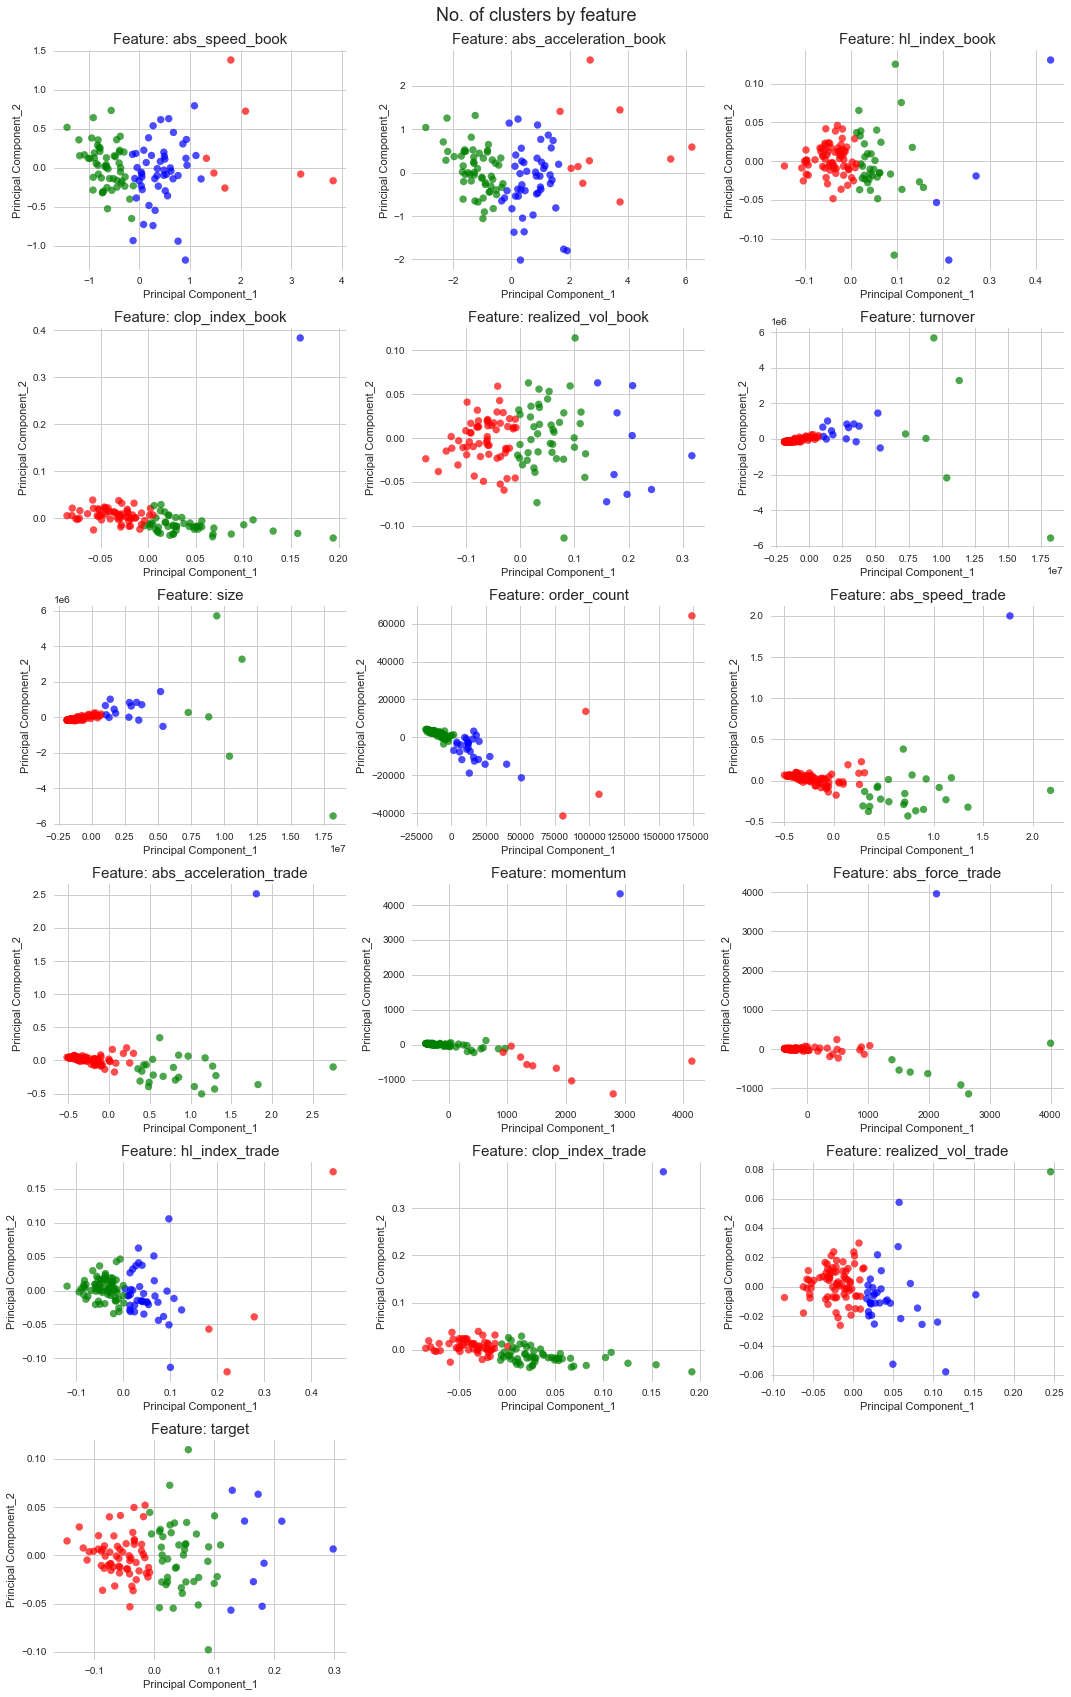

In [643]:
features = [feature for feature in all_features.columns \
            if feature not in ['time_id', 'stock_id']]

plot_clusters(all_features, features, nclusters = 3, ncols=3, figsize=(15,24))

3 clusters does make the plots look more realistic. Indeed, on realized_vol_trade, a feature highly correlated to the target, there are only two clusters with 1 outlier!

# Conclusions

The exploratory analysis of data across the two main files - book_train and trade_train gave the following insights:

* The wap(weighted average bid-ask price) moves like a random walk, while its log returns exhibit stationarity. wap is the key metric on which the realized volatility calculation is based.
* Based on the ACF and PACF analysis, the wap can possibly be modelled using AR(1) and/or AR(2) models. 
* Wap and trade price move in tandem, but it is hard to ascertain which is the driving force.
* Some of the key feature highly correlated to the target (realized volatility of next 10 minutes) are:
            * abs_speed_book
            * abs_acceleration_book
            * realized_volatility_book
            * realized_volatility_trade
            * hl_index_book
            * hl_index_trade

* The features exhibit high concentration around central values and are not normally distributed.
* An analysis of 30 stocks showed that a majority of them show significant correlation on realized volatility, with only a handful of outliers.
* A clustering analysis performed on all the 112 stocks showed that there are 3 clusters on most of the important features like realized volatility, high-low index and absolute speed.
